# Understanding Convolutional Neural Networks (CNNs) and implementing Generative Adversarial Networks (GANs)

## Obtaining and viewing the images
To use this example, you must download the dataset from https://www.kaggle.com/datasets/balraj98/facades-dataset and place it in the `facades` subdirectory of the example code. Otherwise, the example won't be able to find the required information. The original Pix2Pix dataset site is no longer accessible, so older versions of any code using this dataset will need to be updated.

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
# Specify the parameters for using the images. Each image
# file actually contains two 256 X 256 images, an input
# image and a real image. The input image is actually just
# an outline of sorts.
IMG_WIDTH = 256
IMG_HEIGHT = 256
PATH = 'facades/'

In [3]:
# Define a method for loading images into memory from
# the dataset.
def load(image_file):
    raw_image = tf.io.read_file(image_file)
    decode_image = tf.image.decode_jpeg(raw_image)
    image = tf.cast(decode_image, tf.float32)

    return image

In [4]:
# Obtain the input and real image from the appropriate files.
real_image = load(PATH+'trainA/40_A.jpg')
input_image = load(PATH+'trainB/40_B.jpg')

Text(0.5, 1.0, 'Real Image')

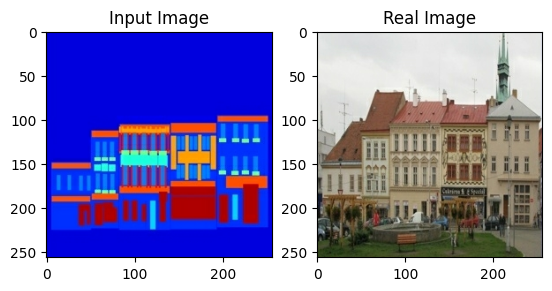

In [5]:
# Cast the input images to int values for MatPlotLib.
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(input_image/255.0)
axes[0].set_title("Input Image")
axes[1].imshow(real_image/255.0)
axes[1].set_title("Real Image")

## Manipulating the images

In [41]:
# Define functions for manipulating the images in various ways.
def resize(input_image, real_image, 
           height, width):
    input_image = tf.image.resize(
        input_image, [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(
        real_image, [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [7]:
@tf.autograph.experimental.do_not_convert
def random_crop(input_image, real_image):
    stacked_image = tf.stack(
        [input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, 
        size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [8]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, 
                                     real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, 
                                          real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

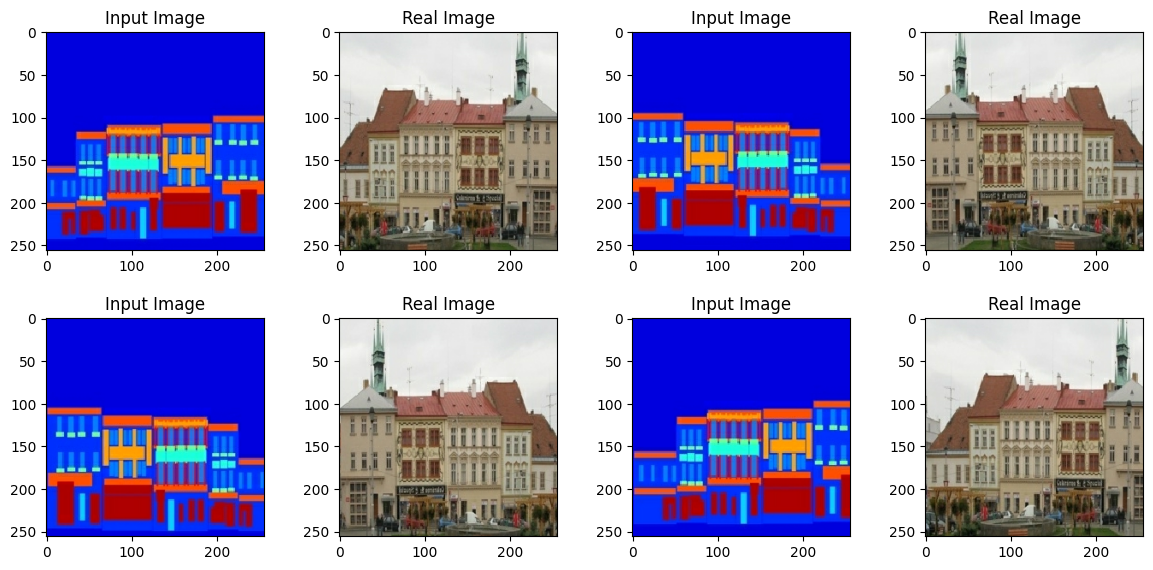

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=4, 
                         figsize=(12, 6))
fig.tight_layout(pad=2)
for i in range(2):
    for j in range(0, 4):
        if j%2 == 0:
            changed_input_image, changed_real_image = \
                random_jitter(input_image, real_image)
            axes[i, j].imshow(changed_input_image/255.0)
            axes[i, j].set_title("Input Image")
            axes[i, j + 1].imshow(
                changed_real_image/255.0)
            axes[i, j + 1].set_title("Real Image")

In [10]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [11]:
normal_input_image, normal_real_image = \
    normalize(input_image, real_image)
print(normal_input_image)

tf.Tensor(
[[[-0.9764706  -0.9764706   0.5294118 ]
  [-0.99215686 -0.9764706   0.5686275 ]
  [-0.99215686 -1.          0.6862745 ]
  ...
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]]

 [[-0.9764706  -0.9764706   0.5294118 ]
  [-0.99215686 -0.9764706   0.5686275 ]
  [-0.99215686 -1.          0.6862745 ]
  ...
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]]

 [[-0.9764706  -0.9764706   0.5294118 ]
  [-0.99215686 -0.9764706   0.5686275 ]
  [-0.99215686 -1.          0.6862745 ]
  ...
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]]

 ...

 [[-0.9764706  -0.96862745  0.5137255 ]
  [-0.99215686 -0.9764706   0.5686275 ]
  [-0.99215686 -0.99215686  0.67058825]
  ...
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.741

## Developing datasets from the modified images

In [12]:
import os

In [13]:
# Load the training image files, apply random jitter to them, 
# then normalize them.
@tf.autograph.experimental.do_not_convert
def load_image_train(files):
    input_image = load(files[0])
    real_image = load(files[1])
    input_image, real_image = \
        random_jitter(input_image, real_image)
    input_image, real_image = \
        normalize(input_image, real_image)

    return input_image, real_image

In [14]:
# Load the testing image files, resize them to 256 X 256,
# then normalize them.
@tf.autograph.experimental.do_not_convert
def load_image_test(files):
    input_image = load(files[0])
    real_image = load(files[1])
    input_image, real_image = \
        resize(input_image, real_image,
               IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = \
        normalize(input_image, real_image)

    return input_image, real_image

In [15]:
# Allow enough space for half the training set and
# create just one batch.
BUFFER_SIZE = 200
BATCH_SIZE = 1

In [16]:
# Create a list of training files
real_files = os.listdir(PATH+'trainA')
real_files = \
    [PATH+'trainA/'+file for file in real_files]
input_files = os.listdir(PATH+'trainB')
input_files = \
    [PATH+'trainB/'+file for file in input_files]
file_list = \
    list(map(list, zip(input_files, real_files)))
for file in file_list:
    print(file)

['facades/trainB/100_B.jpg', 'facades/trainA/100_A.jpg']
['facades/trainB/101_B.jpg', 'facades/trainA/101_A.jpg']
['facades/trainB/102_B.jpg', 'facades/trainA/102_A.jpg']
['facades/trainB/103_B.jpg', 'facades/trainA/103_A.jpg']
['facades/trainB/104_B.jpg', 'facades/trainA/104_A.jpg']
['facades/trainB/105_B.jpg', 'facades/trainA/105_A.jpg']
['facades/trainB/106_B.jpg', 'facades/trainA/106_A.jpg']
['facades/trainB/107_B.jpg', 'facades/trainA/107_A.jpg']
['facades/trainB/108_B.jpg', 'facades/trainA/108_A.jpg']
['facades/trainB/109_B.jpg', 'facades/trainA/109_A.jpg']
['facades/trainB/10_B.jpg', 'facades/trainA/10_A.jpg']
['facades/trainB/110_B.jpg', 'facades/trainA/110_A.jpg']
['facades/trainB/111_B.jpg', 'facades/trainA/111_A.jpg']
['facades/trainB/112_B.jpg', 'facades/trainA/112_A.jpg']
['facades/trainB/113_B.jpg', 'facades/trainA/113_A.jpg']
['facades/trainB/114_B.jpg', 'facades/trainA/114_A.jpg']
['facades/trainB/115_B.jpg', 'facades/trainA/115_A.jpg']
['facades/trainB/116_B.jpg', 'fac

In [17]:
# Create the training dataset.
train_dataset = \
    tf.data.Dataset.from_tensor_slices(file_list)
train_dataset = \
    train_dataset.map(load_image_train, 
                      num_parallel_calls=4)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [18]:
# The result of the loading process is a TensorFlow BatchDataset
# that you can iterate using the following code.
features, label = iter(train_dataset).next()
print("Example features:", features[0])
print("Example label:", label[0]) 

Example features: tf.Tensor(
[[[-0.8901961  -0.60784316  0.47450984]
  [-0.92941177 -0.6392157   0.39607847]
  [-0.9137255  -0.60784316  0.4039216 ]
  ...
  [-0.84313726 -0.6627451   0.5529412 ]
  [-0.8509804  -0.6392157   0.6862745 ]
  [-1.         -0.8352941   0.5529412 ]]

 [[-0.7176471  -0.6313726   0.07450986]
  [-0.7176471  -0.654902    0.01176476]
  [-0.69411767 -0.6313726   0.03529418]
  ...
  [-0.8509804  -0.6862745   0.5137255 ]
  [-0.8745098  -0.6627451   0.6627451 ]
  [-1.         -0.8509804   0.5294118 ]]

 [[ 0.02745104 -0.15294117 -0.0745098 ]
  [ 0.05098045 -0.1607843  -0.12156862]
  [ 0.05882359 -0.14509803 -0.12156862]
  ...
  [-0.8509804  -0.6862745   0.5294118 ]
  [-0.8901961  -0.6862745   0.67058825]
  [-1.         -0.827451    0.60784316]]

 ...

 [[ 0.34901965 -1.         -1.        ]
  [ 0.36470592 -0.99215686 -1.        ]
  [ 0.37254906 -0.99215686 -1.        ]
  ...
  [-0.94509804 -0.6392157   0.9372549 ]
  [-0.8901961  -0.64705884  0.81960785]
  [-1.         

In [19]:
# Create a list of testing files
real_files = os.listdir(PATH+'testA')
real_files = \
    [PATH+'testA/'+file for file in real_files]
input_files = os.listdir(PATH+'testB')
input_files = \
    [PATH+'testB/'+file for file in input_files]
file_list = list(map(list, zip(input_files, 
                               real_files)))

In [20]:
# Create the testing dataset.
test_dataset = \
    tf.data.Dataset.from_tensor_slices(file_list)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Creating the generator

### Defining the downsampling code

In [21]:
OUTPUT_CHANNELS = 3

def downsample(filters, size):
    initializer = tf.random_normal_initializer(
        0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters, size, strides=2, 
            padding='same',
            kernel_initializer=initializer, 
            use_bias=False))
    result.add(
        tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())

    return result

In [22]:
down_model = downsample(3, 4)
down_result = \
    down_model(tf.expand_dims(input_image, 0))
print (down_result.shape)

(1, 128, 128, 3)


### Defining the upsampling code

In [23]:
def upsample(filters, size):
    initializer = tf.random_normal_initializer(
        0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False))
    result.add(
        tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


### Putting the generator together

In [25]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Create the left side of the U by decreasing the image resolution
    # and compressing it.
    down_stack = [
        downsample(64, 4),   # Multi-Channel Feature Map =  128, 128, 64
        downsample(128, 4),  # Multi-Channel Feature Map =  64, 64, 128
        downsample(256, 4),  # Multi-Channel Feature Map =  32, 32, 256
        downsample(512, 4),  # Multi-Channel Feature Map =  16, 16, 512
        downsample(512, 4),  # Multi-Channel Feature Map =  8, 8, 512
        downsample(512, 4),  # Multi-Channel Feature Map =  4, 4, 512
        downsample(512, 4),  # Multi-Channel Feature Map =  2, 2, 512
        downsample(512, 4),  # Multi-Channel Feature Map =  1, 1, 512
    ]

    # Create the right side of the U by increasing the image resolution
    # and decompressing it.
    up_stack = [
        upsample(512, 4),    # Multi-Channel Feature Map =  2, 2, 1024
        upsample(512, 4),    # Multi-Channel Feature Map =  4, 4, 1024
        upsample(512, 4),    # Multi-Channel Feature Map =  8, 8, 1024
        upsample(512, 4),    # Multi-Channel Feature Map =  16, 16, 1024
        upsample(256, 4),    # Multi-Channel Feature Map =  32, 32, 512
        upsample(128, 4),    # Multi-Channel Feature Map =  64, 64, 256
        upsample(64, 4),     # Multi-Channel Feature Map =  128, 128, 128
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    # Multi-Channel Feature Map =  256, 256, 3)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS, 4, strides=2, padding='same',
        kernel_initializer=initializer,
        activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()

### Defining the generator loss function

In [26]:
loss_object = \
    tf.keras.losses.BinaryCrossentropy(
    from_logits=True)

In [27]:
LAMBDA = 100

In [28]:
def generator_loss(disc_generated_output, 
                   gen_output, target):
    gan_loss = loss_object(
        tf.ones_like(disc_generated_output),
        disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(
        tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Creating the discriminator

### Putting the discriminator together

In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(
        shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(
        shape=[256, 256, 3], name='target_image')


    # Multi-Channel Feature Map =  256, 256, channels*2)
    x = tf.keras.layers.concatenate([inp, tar])

    # Multi-Channel Feature Map =  128, 128, 64
    down1 = downsample(64, 4)(x)
    # Multi-Channel Feature Map =  64, 64, 128
    down2 = downsample(128, 4)(down1)
    # Multi-Channel Feature Map =  32, 32, 256
    down3 = downsample(256, 4)(down2)

    # Multi-Channel Feature Map =  34, 34, 256
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    
    # Multi-Channel Feature Map =  31, 31, 512
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    # Multi-Channel Feature Map =  33, 33, 512
    zero_pad2 = \
        tf.keras.layers.ZeroPadding2D()(leaky_relu)

    # Multi-Channel Feature Map =  30, 30, 1
    last = tf.keras.layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()

### Defining the discriminator loss

In [30]:
def discriminator_loss(disc_real_output, 
                       disc_generated_output):
    real_loss = loss_object(
        tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(
        tf.zeros_like(disc_generated_output),
        disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

## Performing optimization of both generator and discriminator

In [31]:
generator_optimizer = \
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = \
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Monitoring the training process

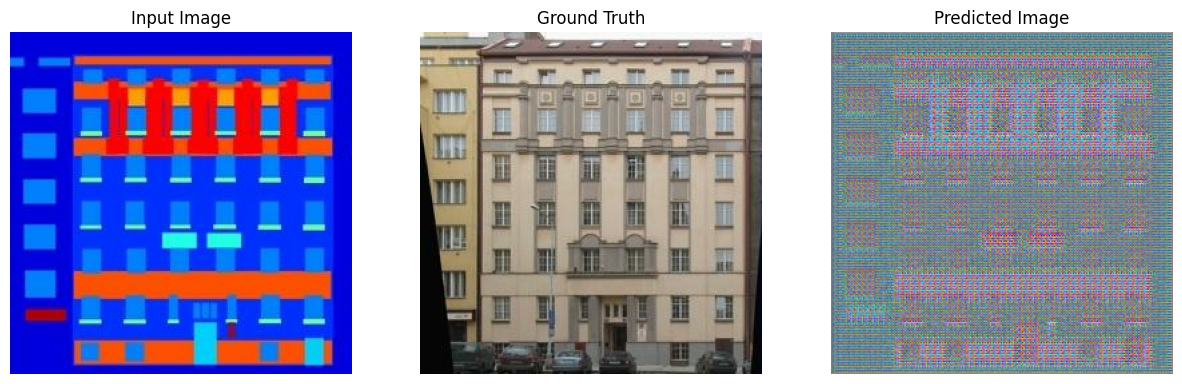

In [32]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 
             'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, 
                    example_target)

## Training the model

### Specifying how to train the model

In [33]:
EPOCHS = 24

@tf.function
@tf.autograph.experimental.do_not_convert
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, \
        tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator(
            [input_image, target], training=True)
        disc_generated_output = discriminator(
            [input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = \
            generator_loss(disc_generated_output, 
                           gen_output, target)
        disc_loss = discriminator_loss(
            disc_real_output, disc_generated_output)

    # Compute the amount to change the model after each training cycle.
    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    # Apply the changes to the model, optimizing the result.
    generator_refittings = 3
    for _ in range(generator_refittings):
        generator_optimizer.apply_gradients(zip(
            generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        discriminator_gradients, discriminator.trainable_variables))

### Defining the fitting function

In [34]:
from IPython import display

In [38]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        display.clear_output(wait=True)

        for example_input, example_target in \
            test_ds.take(1):
            generate_images(generator, 
                            example_input, 
                            example_target)

        print("Epoch: ", epoch)

        # Train
        for n, (input_image, target) in \
            train_ds.enumerate():
            print('.', end='')
            train_step(input_image, target, epoch)
        print()

### Performing the fitting

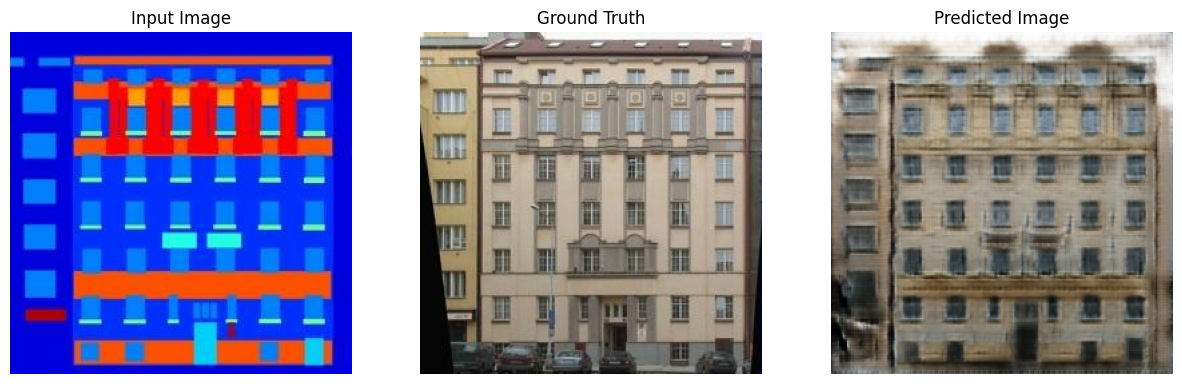

Epoch:  23
................................................................................................................................................................................................................................................................................................................................................................................................................


In [39]:
#%load_ext tensorboard

fit(train_dataset, EPOCHS, test_dataset)

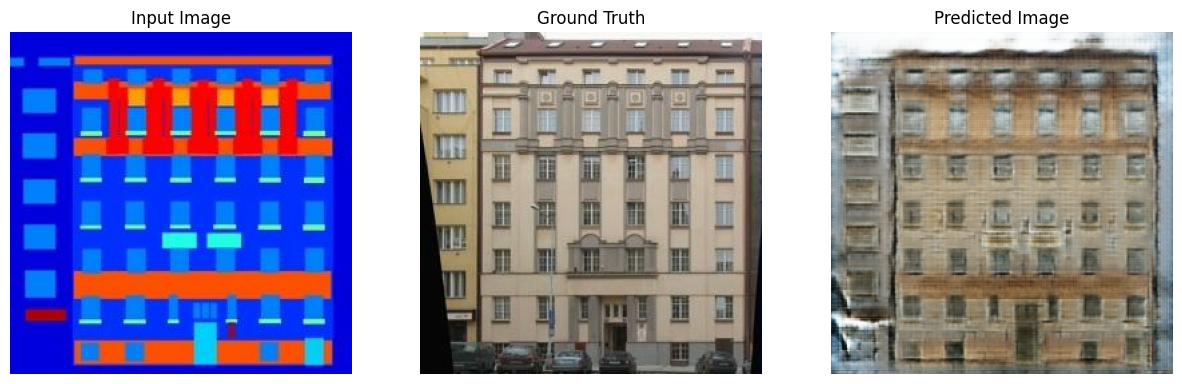

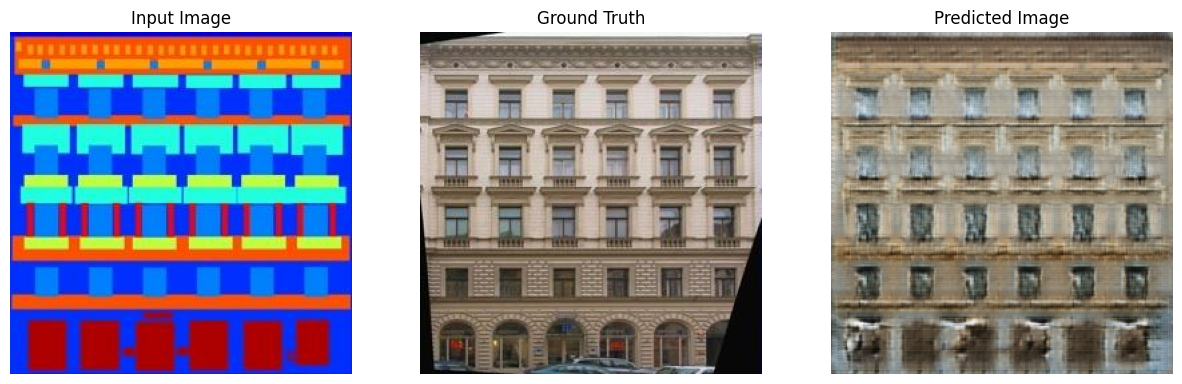

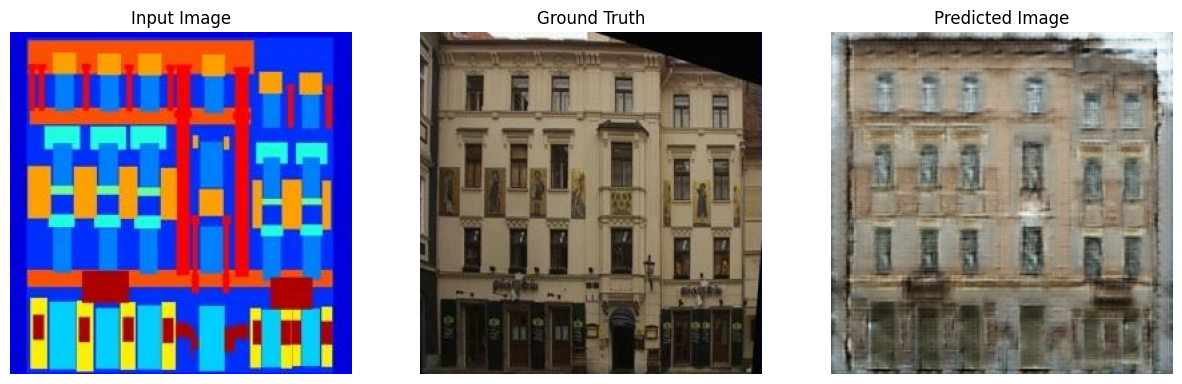

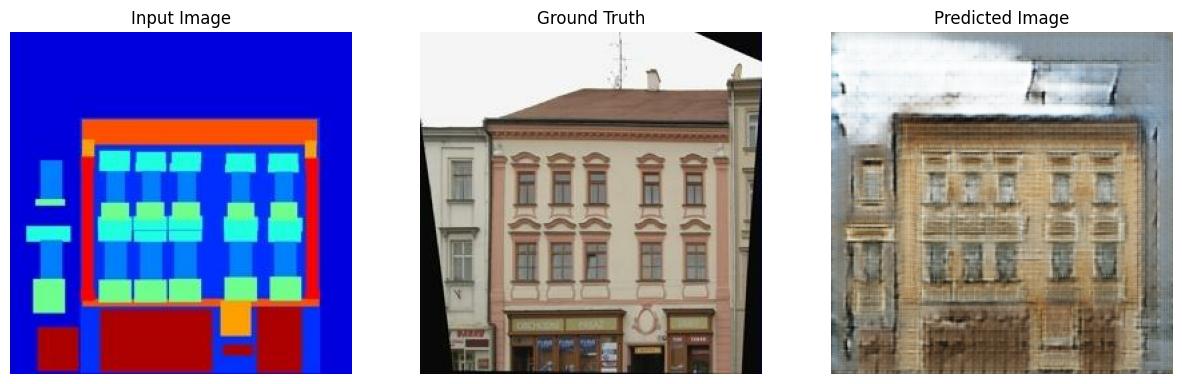

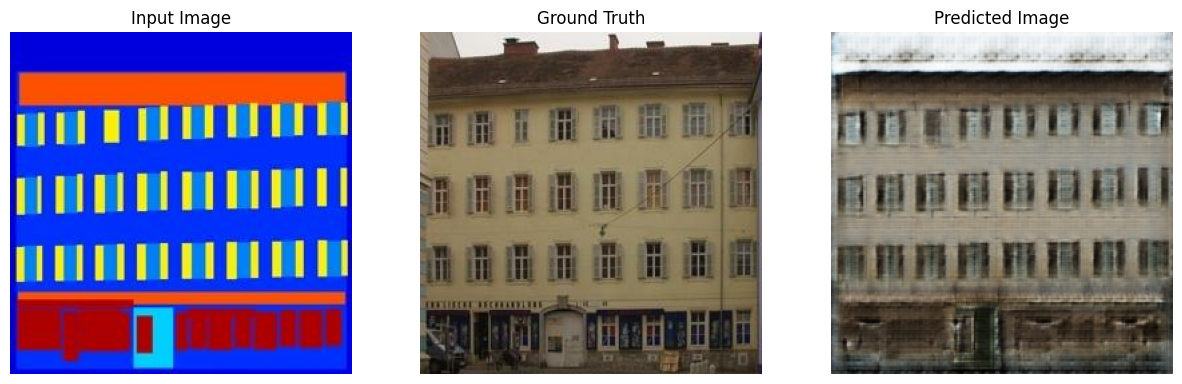

In [40]:
for example_input, example_target in \
    test_dataset.take(5):
    generate_images(generator, example_input, 
                    example_target)